# 自然言語処理とディープラーニング

本章では、テキストデータの基本的な取り扱い方法からニューラルネットワークを用いて、文書の分類を行う方法までを理解、実装することができる事をゴールとします。

自然言語は今までのデータとは異なり、固定の長さのデータではなく、データごとに長さが異なるため、学習の際には固定の長さの数値に落とし込む方法を理解する必要があります。文章を品詞ごとに分割する形態解析、単語を数値化する手法の一つである Bag of Words について学び、自然言語の特徴量変換の方法について学びます。


## 本章の構成


- MeCab で形態素解析
- Bag of Words で特徴量変換
- 文書分類の実装

## MeCab で形態素解析

テキストデータもこれまでのデータと同様に数値化を行う必要があります。まずはどのようにテキストデータをニューラルネットワークの入力値として使用できるようなベクトルに変換できるかの方法について学んでいきます。  

数値化を行う前に文章のようなテキストデータをどのように取り扱うのかについて確認します。  
例えば、「私はキカガクです。」 といった文章を数値化する場合は、下記のように変換を加える事が一般的です。  

> 私 / は / キカガク / です / 。

単語毎に文章を切り分けていることがわかります。このように文章を単語毎に区切り方法の事を **形態素解析 (morphological analysis)** と呼びます。  

形態素解析のプログラムを自身で組む事は非常に困難です。日本語の形態素解析に対してはよく **[MeCab](https://ja.wikipedia.org/wiki/MeCab)** と呼ばれるパッケージを用いる事が多いです。MeCab を使用しての形態素解析の実装方法を確認しましょう。  

### 形態素解析の実装

使用方法は非常にシンプルです。実際に実装しながら確認していきます。Colab 上には MeCab がインストールされていないため、下記のコマンドを実行してインストールを行います。  
ローカル環境にインストールする際は[こちら](https://www.mlab.im.dendai.ac.jp/~yamada/ir/MorphologicalAnalyzer/MeCab.html)を参照して下さい。  



In [91]:
%%capture
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3
!pip install unidic-lite

In [92]:
import MeCab

In [93]:
mecab = MeCab.Tagger('-r /dev/null -d /var/lib/mecab/dic/ipadic-utf8 -Ochasen')

上記のコードでは、`Tagger` クラスをインタンス化しています。引数にある `-Ochasen` とは形態素解析の出力方法を指定しています。詳細はこちらの [Github](https://taku910.github.io/mecab/) を確認して下さい。  


文章の分割には `parse()` メソッドを使用します。  

In [94]:
res = mecab.parse('こんにちは、私はキカガクです。')

In [95]:
print(res)

こんにちは	コンニチハ	こんにちは	感動詞		
、	、	、	記号-読点		
私	ワタシ	私	名詞-代名詞-一般		
は	ハ	は	助詞-係助詞		
キカガク	キカガク	キカガク	名詞-一般		
です	デス	です	助動詞	特殊・デス	基本形
。	。	。	記号-句点		
EOS



`print()` 関数を使用しているため、見た目上はきれいに表示されていますが、形態素解析した結果は下記のように、エスケープシーケンス（改行などを表す特殊な文字列）を多く含みます。

In [96]:
res

'こんにちは\tコンニチハ\tこんにちは\t感動詞\t\t\n、\t、\t、\t記号-読点\t\t\n私\tワタシ\t私\t名詞-代名詞-一般\t\t\nは\tハ\tは\t助詞-係助詞\t\t\nキカガク\tキカガク\tキカガク\t名詞-一般\t\t\nです\tデス\tです\t助動詞\t特殊・デス\t基本形\n。\t。\t。\t記号-句点\t\t\nEOS\n'

このように分割されたテキストデータはエスケープシーケンスを取り除き、単語ごとに抽出を行う処理を施す必要があります。  

形態素解析を行い、単語ごとに文章を分割ができました。次のステップは分割された単語を数値に変換していく事になります。  

### 名詞の抽出

本章で取り組む文書分類の問題設定をここで確認しておきましょう。分類を行う文書は下記の 9 つのニュースサイトの記事となります。    

| 名前                                                         | 概要                                                   |
| ------------------------------------------------------------ | ------------------------------------------------------ |
| [ITライフハック](http://itlifehack.jp/)                      | IT関連情報をお届けするIT生活とビジネスのお役立ちサイト |
| [家電チャンネル](http://kadench.jp/)                         | 家電情報をお届けするlifestyle支援サイト                |
| livedoor HOMME                                               | 男性向けライフスタイルWebマガジン                      |
| [トピックニュース](https://news.livedoor.com/category/vender/news/) | 時事・芸能ニュースを取扱う                             |
| [Sports Watch](https://news.livedoor.com/category/vender/208/) | スポーツニュースを取扱う                               |
| [MOVIE ENTER](https://news.livedoor.com/category/vender/movie_enter/) | 映画関連のニュースを取扱う                             |
| [独女通信](http://dokujo.jp/)                                | 20歳以上の独身女性の本音を扱うコラム                   |
| [エスマックス](https://news.livedoor.com/category/vender/smax/) | モバイル関連情報・ニュースを取扱う                     |
| [Peachy](https://news.livedoor.com/article/category/55/)     | 恋愛・グルメなどを取扱う女性のためのニュースサイト   |

*データセット引用元 : [livedoor ニュースコーパス](https://www.rondhuit.com/download.html#ldcc)*  

入力値は各記事（文書）をとり、目的値はどのニュースサイトなのかのラベルになります。  

文書の例も先に確認しておきましょう。下記は IT ライフハックの記事から一部文章を抜粋したものになります。    

```
旧式Macで禁断のパワーアップ！最新PCやソフトを一挙にチェック【ITフラッシュバック】
テレビやTwitterと連携できるパソコンや、 ...
```

他の記事の文章も確認しておきましょう。下記の文章は Sports Watch から一部抜粋したものになります。  

```
バルセロナ五輪柔道金メダリストとしての実績を引っさげ、2002年にプロ総合格闘家に転向。以後、数々の死闘を繰り広げてきた吉田。昨年大晦日のDynamite!!では、石井慧との金メダリスト対決
```
これらの文書を数値化し、分類を行う問題設定になります。数値化は全ての分割した単語の全ての品詞に適用してもいいですが今回は品詞を絞り数値化します。  

上記 2 つの記事を分類する際には単語の中でもどの品詞が重要と考えられるでしょうか。IT ライフハックの記事では、Mac や PC 、ソフトといった名詞が確認でき、Sports Watch の記事では柔道、金メダル、プロのようなスポーツならではの名詞が使用されている事が確認できます。  

このように今回の問題設定では名詞を用いて分類を行うことが可能な事が想定されます。文章の形態素解析から名詞の抽出方法について確認します。    

練習として、下記の ３ つの文章から名詞の抽出を行います。

In [97]:
text1 = 'キカガクでは、ディープラーニングを含んだ機械学習や人工知能の教育を行っています。'
text2 = '代表の吉崎は大学院では機械学習・ロボットのシステム制御、画像処理の研究に携わっていました。'
text3 = '機械学習、システム制御、画像処理ではすべて線形代数とプログラミングが不可欠になります。'

In [98]:
# 形態素解析
res = mecab.parse(text1)
print(res)

キカガク	キカガク	キカガク	名詞-一般		
で	デ	で	助詞-格助詞-一般		
は	ハ	は	助詞-係助詞		
、	、	、	記号-読点		
ディープラーニング	ディープラーニング	ディープラーニング	名詞-一般		
を	ヲ	を	助詞-格助詞-一般		
含ん	フクン	含む	動詞-自立	五段・マ行	連用タ接続
だ	ダ	だ	助動詞	特殊・タ	基本形
機械	キカイ	機械	名詞-一般		
学習	ガクシュウ	学習	名詞-サ変接続		
や	ヤ	や	助詞-並立助詞		
人工	ジンコウ	人工	名詞-一般		
知能	チノウ	知能	名詞-一般		
の	ノ	の	助詞-連体化		
教育	キョウイク	教育	名詞-サ変接続		
を	ヲ	を	助詞-格助詞-一般		
行っ	オコナッ	行う	動詞-自立	五段・ワ行促音便	連用タ接続
て	テ	て	助詞-接続助詞		
い	イ	いる	動詞-非自立	一段	連用形
ます	マス	ます	助動詞	特殊・マス	基本形
。	。	。	記号-句点		
EOS



形態素解析を行ったテキストデータは下記のようにエスケープシーケンスが含まれていました。  
それぞれを改行 (`\n`) で分割を行います。特定の文字列でテキストデータを分けるときは、`split()` メソッドを使用します。

In [99]:
res

'キカガク\tキカガク\tキカガク\t名詞-一般\t\t\nで\tデ\tで\t助詞-格助詞-一般\t\t\nは\tハ\tは\t助詞-係助詞\t\t\n、\t、\t、\t記号-読点\t\t\nディープラーニング\tディープラーニング\tディープラーニング\t名詞-一般\t\t\nを\tヲ\tを\t助詞-格助詞-一般\t\t\n含ん\tフクン\t含む\t動詞-自立\t五段・マ行\t連用タ接続\nだ\tダ\tだ\t助動詞\t特殊・タ\t基本形\n機械\tキカイ\t機械\t名詞-一般\t\t\n学習\tガクシュウ\t学習\t名詞-サ変接続\t\t\nや\tヤ\tや\t助詞-並立助詞\t\t\n人工\tジンコウ\t人工\t名詞-一般\t\t\n知能\tチノウ\t知能\t名詞-一般\t\t\nの\tノ\tの\t助詞-連体化\t\t\n教育\tキョウイク\t教育\t名詞-サ変接続\t\t\nを\tヲ\tを\t助詞-格助詞-一般\t\t\n行っ\tオコナッ\t行う\t動詞-自立\t五段・ワ行促音便\t連用タ接続\nて\tテ\tて\t助詞-接続助詞\t\t\nい\tイ\tいる\t動詞-非自立\t一段\t連用形\nます\tマス\tます\t助動詞\t特殊・マス\t基本形\n。\t。\t。\t記号-句点\t\t\nEOS\n'

In [100]:
# 改行ごとに分割し、リストに格納
res.split('\n')

['キカガク\tキカガク\tキカガク\t名詞-一般\t\t',
 'で\tデ\tで\t助詞-格助詞-一般\t\t',
 'は\tハ\tは\t助詞-係助詞\t\t',
 '、\t、\t、\t記号-読点\t\t',
 'ディープラーニング\tディープラーニング\tディープラーニング\t名詞-一般\t\t',
 'を\tヲ\tを\t助詞-格助詞-一般\t\t',
 '含ん\tフクン\t含む\t動詞-自立\t五段・マ行\t連用タ接続',
 'だ\tダ\tだ\t助動詞\t特殊・タ\t基本形',
 '機械\tキカイ\t機械\t名詞-一般\t\t',
 '学習\tガクシュウ\t学習\t名詞-サ変接続\t\t',
 'や\tヤ\tや\t助詞-並立助詞\t\t',
 '人工\tジンコウ\t人工\t名詞-一般\t\t',
 '知能\tチノウ\t知能\t名詞-一般\t\t',
 'の\tノ\tの\t助詞-連体化\t\t',
 '教育\tキョウイク\t教育\t名詞-サ変接続\t\t',
 'を\tヲ\tを\t助詞-格助詞-一般\t\t',
 '行っ\tオコナッ\t行う\t動詞-自立\t五段・ワ行促音便\t連用タ接続',
 'て\tテ\tて\t助詞-接続助詞\t\t',
 'い\tイ\tいる\t動詞-非自立\t一段\t連用形',
 'ます\tマス\tます\t助動詞\t特殊・マス\t基本形',
 '。\t。\t。\t記号-句点\t\t',
 'EOS',
 '']

最後に 2 行に EOS (End Of Sentence) と空白が入ってしまっているため、最後 2 つの要素までをスライスして使用します。

In [101]:
# 最後の 2 つの要素までをスライス
res.split('\n')[:-2]

['キカガク\tキカガク\tキカガク\t名詞-一般\t\t',
 'で\tデ\tで\t助詞-格助詞-一般\t\t',
 'は\tハ\tは\t助詞-係助詞\t\t',
 '、\t、\t、\t記号-読点\t\t',
 'ディープラーニング\tディープラーニング\tディープラーニング\t名詞-一般\t\t',
 'を\tヲ\tを\t助詞-格助詞-一般\t\t',
 '含ん\tフクン\t含む\t動詞-自立\t五段・マ行\t連用タ接続',
 'だ\tダ\tだ\t助動詞\t特殊・タ\t基本形',
 '機械\tキカイ\t機械\t名詞-一般\t\t',
 '学習\tガクシュウ\t学習\t名詞-サ変接続\t\t',
 'や\tヤ\tや\t助詞-並立助詞\t\t',
 '人工\tジンコウ\t人工\t名詞-一般\t\t',
 '知能\tチノウ\t知能\t名詞-一般\t\t',
 'の\tノ\tの\t助詞-連体化\t\t',
 '教育\tキョウイク\t教育\t名詞-サ変接続\t\t',
 'を\tヲ\tを\t助詞-格助詞-一般\t\t',
 '行っ\tオコナッ\t行う\t動詞-自立\t五段・ワ行促音便\t連用タ接続',
 'て\tテ\tて\t助詞-接続助詞\t\t',
 'い\tイ\tいる\t動詞-非自立\t一段\t連用形',
 'ます\tマス\tます\t助動詞\t特殊・マス\t基本形',
 '。\t。\t。\t記号-句点\t\t']

次に、一番最初の要素に対して、タブ (`\t`) で分割を行います。

In [102]:
# 1 つ目の単語をスライス
res.split('\n')[0]

'キカガク\tキカガク\tキカガク\t名詞-一般\t\t'

こちらの結果から名詞であるかどうかを判定するためには、左から 4 番目（要素番号 3）にアクセスすれば品詞を取得することができます。

In [103]:
# 品詞の取得
res .split('\n')[0].split('\t')[3]

'名詞-一般'

上記一連の流れを for 文を用いて文章全体に適用し、品詞が名詞の単語のみを抽出し、リストに格納します。

In [104]:
nouns = [] # 品詞が名詞 (noun) である単語を格納するリスト
res = mecab.parse(text1)
words = res.split('\n')[:-2]
for word in words:
    part = word.split('\t')
    if '名詞' in part[3]:
        nouns.append(part[0])

In [105]:
nouns

['キカガク', 'ディープラーニング', '機械', '学習', '人工', '知能', '教育']

上記のプログラムを関数化し、text1 ~ 3 の文章からも同様に名詞の抽出を行います。

In [106]:
def get_nouns(text):
    nouns = []
    res = mecab.parse(text)
    words = res.split('\n')[:-2]
    for word in words:
        part = word.split('\t')
        if '名詞' in part[3]:
            nouns.append(part[0])
    return nouns

In [107]:
nouns1 = get_nouns(text1)
nouns1

['キカガク', 'ディープラーニング', '機械', '学習', '人工', '知能', '教育']

In [108]:
nouns2 = get_nouns(text2)
nouns2

['代表', '吉崎', '大学院', '機械', '学習', 'ロボット', 'システム', '制御', '画像', '処理', '研究']

In [109]:
nouns3 = get_nouns(text3)
nouns3

['機械', '学習', 'システム', '制御', '画像', '処理', 'すべて', '線形', '代数', 'プログラミング', '不可欠']

## 自然言語の特徴量変換

自然言語の特徴量変換には様々な手法が存在します。その方法は多種多様であり、どの手法を用いるかは問題設定に応じて変更する必要があります。下記は基礎的なテキストデータのエンコーディング方法（ベクトル化）になります。  

- Bag of Words (Count encoding)
- [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
- [One-hot encoding](https://en.wikipedia.org/wiki/One-hot)
- [Word2Vec](https://en.wikipedia.org/wiki/Word2vec)

本章ではエンコーディング手法の中で最もシンプルなものの 1 つである Bag of Words を用いてのエンコーディング方法を確認します。  


### Bag of Words の概要

Bag of Words （以下 BoW）とは、単語の出現回数によって単語を数値に変換する方法です。

次の ３ つの文章を BoW を用いてエンコーディングを行った場合の結果を確認しましょう。  

1. 私は電車が好きです。
2. 電車より車をよく使います。
3. 好きな果物はりんごです。

3 つの文に出現する単語をすべて羅列します。この出現する単語から重複を取り除いたものを**辞書 (dictionary)** と呼びます。

［ 私　は　電車　が　好き　です　より　車　を　よく　使い　ます　な　果物　りんご ］

各文章に対し、羅列した単語を出現数に変換します。  

1. ［ 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 ］
2. ［ 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 ］
3. ［ 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 ］

### BoW の実装

前節で取得した名詞のリストを BoW で、エンコーディングを行いましょう。BoW の実装は scikit-learn を用います。scikit-learn を用いる場合、テキストデータは単語ごとに半角スペース区切りになっている必要があります。`join()` メソッドを用いることでリストの要素を繋げる事が可能です。  

In [110]:
nouns1

['キカガク', 'ディープラーニング', '機械', '学習', '人工', '知能', '教育']

In [111]:
# 要素を半角スペースで結合
' '.join(nouns1)

'キカガク ディープラーニング 機械 学習 人工 知能 教育'

上記の処理を text1 ~ 3 全てに適用し、1 つのリストに格納します。

In [112]:
nouns_list = [nouns1, nouns2, nouns3]
corpus = []
for nouns in nouns_list:
  corpus.append(' '.join(nouns))

In [113]:
corpus

['キカガク ディープラーニング 機械 学習 人工 知能 教育',
 '代表 吉崎 大学院 機械 学習 ロボット システム 制御 画像 処理 研究',
 '機械 学習 システム 制御 画像 処理 すべて 線形 代数 プログラミング 不可欠']

`CountVectorizer` クラスを使用します。インスタンス化後に `fit_transform()` メソッドを使用すると、前述の説明通り、単語毎に ID が割り振られ、ID ごとの出現回数を元にベクトル化が行われます。

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(corpus)

`vocabulary_` 属性にはエンコーディングされた単語とその ID を確認することができます。  

テキストデータには 21 個の重複のない名詞があることが確認できます。

In [115]:
vectorizer.vocabulary_

{'キカガク': 1,
 'ディープラーニング': 3,
 '機械': 16,
 '学習': 14,
 '人工': 7,
 '知能': 18,
 '教育': 15,
 '代表': 9,
 '吉崎': 12,
 '大学院': 13,
 'ロボット': 5,
 'システム': 2,
 '制御': 11,
 '画像': 17,
 '処理': 10,
 '研究': 19,
 'すべて': 0,
 '線形': 20,
 '代数': 8,
 'プログラミング': 4,
 '不可欠': 6}

エンコーディング後の数値は `toarray()` メソッドを使用して取得します。


In [116]:
x = x.toarray()
print(x)

[[0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0]
 [0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0]
 [1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1]]


エンコーディング後の数値を確認して、エンコーディングが想定通りなされているか確認しましょう。  

1 つ目のリストの数値が 1 となっている要素番号は次になります。1, 3, 7, 14, 15, 16, 18 です。こちらをエンコーディング前の単語に当てはめると下記の単語を取得することができます。  

```
 'キカガク': 1,
 'ディープラーニング': 3,
 '人工': 7,
 '学習': 14,
 '教育': 15,
 '機械': 16,
 '知能': 18,
```

1 つ目の名詞リストと同じものは入っていること確認できました。BoW を用いてのベクトル化の方法が理解できました。文書分類に取り組んで行きましょう。  



## 文書分類の実装

実際のデータセットを用いて、文書分類の実装を行います。
データセットは[こちら](https://drive.google.com/file/d/1hiBKfaX4iq62IGaFxPw4duubbAL4aMK-/view?usp=sharing)からダウンロードし、Colab 上にアップロードを行って下さい。（アップロードには約 1 ~ 5 分ほどかかります。）  


In [117]:
from google.colab import files
uploaded = files.upload()

Saving texts.zip to texts (1).zip


ファイルは zip 形式のファイルになります。次のコマンドを実行し、解凍します。

In [156]:
!unzip -o texts.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: texts/sports-watch/sports-watch-4747870.txt  
  inflating: __MACOSX/texts/sports-watch/._sports-watch-4747870.txt  
  inflating: texts/sports-watch/sports-watch-5905383.txt  
  inflating: __MACOSX/texts/sports-watch/._sports-watch-5905383.txt  
  inflating: texts/sports-watch/sports-watch-5785824.txt  
  inflating: __MACOSX/texts/sports-watch/._sports-watch-5785824.txt  
  inflating: texts/sports-watch/sports-watch-6529613.txt  
  inflating: __MACOSX/texts/sports-watch/._sports-watch-6529613.txt  
  inflating: texts/sports-watch/sports-watch-4627799.txt  
  inflating: __MACOSX/texts/sports-watch/._sports-watch-4627799.txt  
  inflating: texts/sports-watch/sports-watch-6856472.txt  
  inflating: __MACOSX/texts/sports-watch/._sports-watch-6856472.txt  
  inflating: texts/sports-watch/sports-watch-6804334.txt  
  inflating: __MACOSX/texts/sports-watch/._sports-watch-6804334.txt  
  inflating: texts/sports-watch/sports-watch-5314528.txt  
  infl

In [157]:
# 解凍したファイルの確認
!ls texts/

dokujo-tsushin	kaden-channel	movie-enter  smax	   topic-news
it-life-hack	livedoor-homme	peachy	     sports-watch


今回使用するデータセットの概要をもう一度確認します。  

| 名前                                                         | 概要                                                   |
| ------------------------------------------------------------ | ------------------------------------------------------ |
| [ITライフハック](http://itlifehack.jp/)                      | IT関連情報をお届けするIT生活とビジネスのお役立ちサイト |
| [家電チャンネル](http://kadench.jp/)                         | 家電情報をお届けするlifestyle支援サイト                |
| livedoor HOMME                                               | 男性向けライフスタイルWebマガジン                      |
| [トピックニュース](https://news.livedoor.com/category/vender/news/) | 時事・芸能ニュースを取扱う                             |
| [Sports Watch](https://news.livedoor.com/category/vender/208/) | スポーツニュースを取扱う                               |
| [MOVIE ENTER](https://news.livedoor.com/category/vender/movie_enter/) | 映画関連のニュースを取扱う                             |
| [独女通信](http://dokujo.jp/)                                | 20歳以上の独身女性の本音を扱うコラム                   |
| [エスマックス](https://news.livedoor.com/category/vender/smax/) | モバイル関連情報・ニュースを取扱う                     |
| [Peachy](https://news.livedoor.com/article/category/55/)     | 恋愛・グルメなどを取扱う女性のためのニュースサイト   |


### 入力・目標値作成

テキストファイルごとに BoW を用いてエンコーディングを行います。また、それぞれのテキストファイルごとにどのカテゴリの文書なのかの目標値の作成も行います。  

Python でファイルやディレクトリを操作するときに便利なパッケージに glob があります。glob を用いてファイルの読み込みを行います。

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
from glob import glob

In [160]:
# text ディレクトリ以下のディレクトリの取得
directories = sorted(glob('texts/*'))
directories

['texts/dokujo-tsushin',
 'texts/it-life-hack',
 'texts/kaden-channel',
 'texts/livedoor-homme',
 'texts/movie-enter',
 'texts/peachy',
 'texts/smax',
 'texts/sports-watch',
 'texts/topic-news']

入力値と目標値の作成を行う方法を順を追って確認を行います。取得したディレクトリ名の中から 1 つ目の要素を取り出し中身の確認を行います。

In [161]:
filepaths = sorted(glob('{}/*.txt'.format(directories[0])))
filepaths[:3]

['texts/dokujo-tsushin/LICENSE.txt',
 'texts/dokujo-tsushin/dokujo-tsushin-4778030.txt',
 'texts/dokujo-tsushin/dokujo-tsushin-4778031.txt']

1 つ目のディレクトリ内のテキストファイル名の取得を行うことができました。ファイルの展開には `with` 構文を用います。読み込んだ際に `[2:]` で空白と日付が含まれる最初の 2 つの要素を除外しています。

In [162]:
with open(filepaths[0], encoding='utf-8') as f:
  text = ''.join(f.readlines()[2:])
print(text)

原著作者のクレジットを表示し、ニュース記事の改変をしないことを条件に、記事全文を
自由に転載・引用が可能です。

このディレクトリの記事ファイル内容の提供元：
独女通信
http://news.livedoor.com/category/vender/90/



取り出したこの 1 テキストファイルが入力値になります。このテキストデータからこの記事がどのカテゴリに属するのかの分類を行います。  

各ディレクトリに対応する要素番号を分類に使用するラベルとして使用します。`enumerate()` を使うことで、for 文を用いて繰り返しを実行する際に要素番号も併せて取得することができます。  

In [163]:
for (i, directory) in enumerate(directories):
    print(i, directory)
    print('- - -')

0 texts/dokujo-tsushin
- - -
1 texts/it-life-hack
- - -
2 texts/kaden-channel
- - -
3 texts/livedoor-homme
- - -
4 texts/movie-enter
- - -
5 texts/peachy
- - -
6 texts/smax
- - -
7 texts/sports-watch
- - -
8 texts/topic-news
- - -


全てのディレクトリ・テキストファイルを読み込み、同時にラベル付けも行います。

In [164]:
texts, labels = [], []
for (i, directory) in enumerate(directories):
    #各ディレクトリ内のtxtファイルのパスをすべて取得
    filepaths = sorted(glob('{}/*.txt'.format(directory)))
    # テキストを読み込んで、内容をtextに格納、ラベルも併せて格納
    for filepath in filepaths:
        with open(filepath, encoding='utf-8') as f:
            text = ''.join(f.readlines()[2:])  # URL等の先頭２行を除いた各行の文章を連結（join）して格納
            texts.append(text)
            labels.append(i)

取り出したテキストデータとラベルを確認します。

In [165]:
len(texts), len(labels)

(7278, 7278)

In [166]:
texts[0]

'原著作者のクレジットを表示し、ニュース記事の改変をしないことを条件に、記事全文を\n自由に転載・引用が可能です。\n\nこのディレクトリの記事ファイル内容の提供元：\n独女通信\nhttp://news.livedoor.com/category/vender/90/\n'

In [167]:
labels[0]

0

### 文章から名詞のみを抽出

前に作成した名詞抽出用の関数を使用して、文書全体で使用されている名詞を全て `word_collect` というリストに格納していきましょう。

In [168]:
def get_nouns(text):
    nouns = []
    res = mecab.parse(text)
    words = res.split('\n')[:-2]
    for word in words:
        part = word.split('\t')
        if '名詞' in part[3]:
            nouns.append(part[0])
    return nouns

それぞれのテキストデータに対し名詞抽出を行う関数を適用し、リストに追加する前に半角スペース区切りの文字列に変換を行います。

In [169]:
word_collect = []
for text in texts:
    nouns = get_nouns(text)
    word_collect.append(' '.join(nouns))

In [170]:
word_collect[0]

'原 著作 者 クレジット 表示 ニュース 記事 改変 こと 条件 記事 全文 自由 転載 引用 可能 ディレクトリ 記事 ファイル 内容 提供 元 独 女 通信 http :// news . livedoor . com / category / vender / 90 /'

### BoW に変換

全ての名詞を使用して辞書を作成した場合、使用される単語量が膨大になることが想定されます。（約 5 万単語） そのため、今回はエンコーディング時に引数 `min_df` を指定し、出現頻度が指定した値以下のものは取り扱わない設定を行います。  

詳細に関してはこちらの[公式ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)を確認して下さい。  

In [171]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=20)
x = vectorizer.fit_transform(word_collect)
x = x.toarray()

In [172]:
len(vectorizer.vocabulary_)

6378

In [173]:
len(x)

7278

In [174]:
x = x.astype('float32')
t = np.array(labels, 'int32')

## 練習問題 本章のまとめ

本章で学んだ内容を復習しましょう。下記の内容を次のセルに記述し、実行結果を確認してください。（必要に応じてセルの追加を行ってください。）

作成したデータセットを使用して、ニューラルネットワークの実装を行って下さい。モデルの定義・学習・評価を行い、文書分類がどの程度の精度で行うことができているのか確認して下さい。  

*手順*  

- 学習用データセットとテスト用データセットに分割 : テスト用データセットが全体の 30% 、random_state は 0 で指定して下さい。
- モデルの定義 : 中間層・ノードの数の調整を行って下さい。
- モデルの学習 : 最適化の手法の選択、学習係数・エポック数などの調整を行って下さい。  
- モデルの評価 : 損失、正解率の両方の学習結果をプロットして下さい。


*発展（時間が余った方は下記の内容に取り組んでみて下さい。）*　    

- 名詞ではなく、その他の品詞を使用してのデータセット作成
- `CountVectorizer` クラスを用いてエンコーディングする際のハイパーパラメータの調整（[こちら](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)を参照して下さい。）
- その他のエンコーディング手法（tf-idf など）の実装（[こちら](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)を参照して下さい。）

In [175]:
import tensorflow as tf

In [176]:
import os
import random
from sklearn.model_selection import train_test_split

def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [177]:
# 学習用データセットとテスト用データセットに分割
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.3, shuffle=False)

In [178]:
# モデルの定義
from tensorflow.keras import models, layers

reset_seed(0)

model = models.Sequential()

model.add(layers.Dense(5, input_shape=(x_train.shape[1],), activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 5)              │        31,895 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,949 (124.80 KB)

 Trainable params: 31,949 (124.80 KB)

 Non-trainable params: 0 (0.00 B)

In [179]:
# 目的関数と最適化手法の選択
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [180]:
# モデルの学習

history = model.fit(x_train, t_train,
          batch_size=100,
          epochs=20,
          validation_data=(x_test, t_test)
          )

Shape of x_train: (5094, 6378)
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2696 - loss: 2.0582 - val_accuracy: 0.1873 - val_loss: 2.0150
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5250 - loss: 1.5203 - val_accuracy: 0.1960 - val_loss: 2.0536
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5710 - loss: 1.2793 - val_accuracy: 0.2010 - val_loss: 2.1281
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6610 - loss: 1.1231 - val_accuracy: 0.2024 - val_loss: 2.2245
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7426 - loss: 0.9992 - val_accuracy: 0.2038 - val_loss: 2.3336
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8065 - loss: 0.8947 - val_accuracy: 0.2070 - val_loss: 2.4459
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8251 - loss: 0.8054 - val_accuracy: 0.2083 - val_loss: 2.5543
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8395 - loss: 0.7295 - 

In [181]:
# モデルの評価
results = pd.DataFrame(history.history)
results.head(5)

,accuracy,loss,val_accuracy,val_loss
0,0.381822,1.896626,0.187271,2.015013
1,0.546918,1.441078,0.195971,2.053627
2,0.592069,1.226259,0.201007,2.128097
3,0.687083,1.080018,0.202381,2.224466
4,0.762269,0.962800,0.203755,2.333557


Text(0.5, 0, 'epochs')

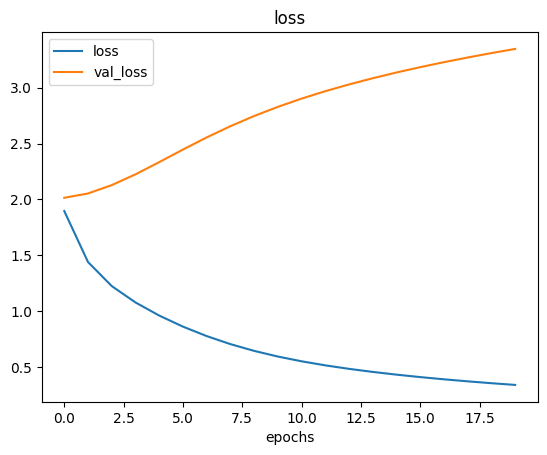

In [182]:
# 損失を可視化
results[['loss', 'val_loss']].plot(title='loss')
plt.xlabel('epochs')


Text(0.5, 0, 'epochs')

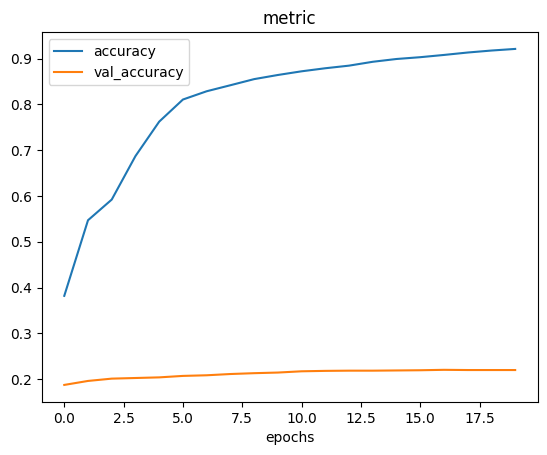

In [183]:
# 正解率を可視化
results[['accuracy', 'val_accuracy']].plot(title='metric')
plt.xlabel('epochs')

In [184]:
def get_verbs(text):
    verbs = []
    res = mecab.parse(text)
    words = res.split('\n')[:-2]
    for word in words:
        part = word.split('\t')
        if '動詞' in part[3]:
            verbs.append(part[0])
    return verbs

verbs_collect = []
for text in texts:
    verbs = get_verbs(text)
    verbs_collect.append(' '.join(verbs))


In [147]:
verbs_collect[0]

'し し ない 自由 可能 です'

In [148]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=20)
x = vectorizer.fit_transform(verbs_collect)
x = x.toarray()

In [149]:
len(vectorizer.vocabulary_)

2035

In [150]:
len(x)

7278

In [151]:
x = x.astype('float32')
t = np.array(labels, 'int32')

In [152]:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.3, shuffle=False)

In [153]:
# モデルの定義
from tensorflow.keras import models, layers

reset_seed(0)

model = models.Sequential()

model.add(layers.Dense(5, input_shape=(x_train.shape[1],), activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 5)              │        10,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,234 (39.98 KB)

 Trainable params: 10,234 (39.98 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [185]:
print("Shape of x_train:", x_train.shape)

history = model.fit(x_train, t_train,
          batch_size=100,
          epochs=20,
          validation_data=(x_test, t_test)
          )

Shape of x_train: (5094, 6378)
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9205 - loss: 0.3337 - val_accuracy: 0.2198 - val_loss: 3.3808
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9250 - loss: 0.3199 - val_accuracy: 0.2198 - val_loss: 3.4147
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9291 - loss: 0.3070 - val_accuracy: 0.2202 - val_loss: 3.4471
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9320 - loss: 0.2950 - val_accuracy: 0.2207 - val_loss: 3.4785
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9359 - loss: 0.2836 - val_accuracy: 0.2207 - val_loss: 3.5087
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9406 - loss: 0.2729 - val_accuracy: 0.2207 - val_loss: 3.5380
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9418 - loss: 0.2628 - val_accuracy: 0.2212 - val_loss: 3.5664
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9437 - loss: 0.2533 - v

In [186]:
results = pd.DataFrame(history.history)
results.head(5)

,accuracy,loss,val_accuracy,val_loss
0,0.924421,0.328677,0.219780,3.380754
1,0.928543,0.315388,0.219780,3.414681
2,0.931684,0.302967,0.220238,3.447098
3,0.934433,0.291319,0.220696,3.478470
4,0.937181,0.280378,0.220696,3.508693


Text(0.5, 0, 'epochs')

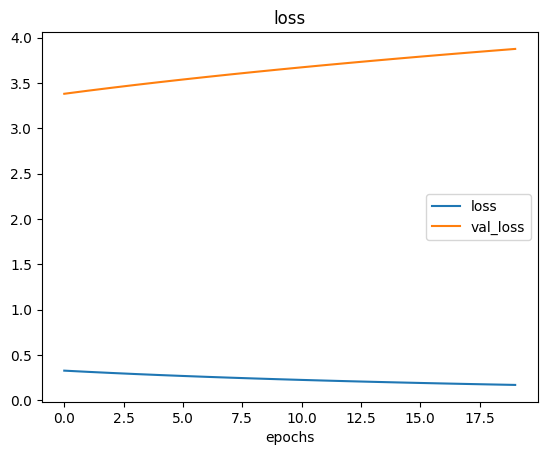

In [187]:
results[['loss', 'val_loss']].plot(title='loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

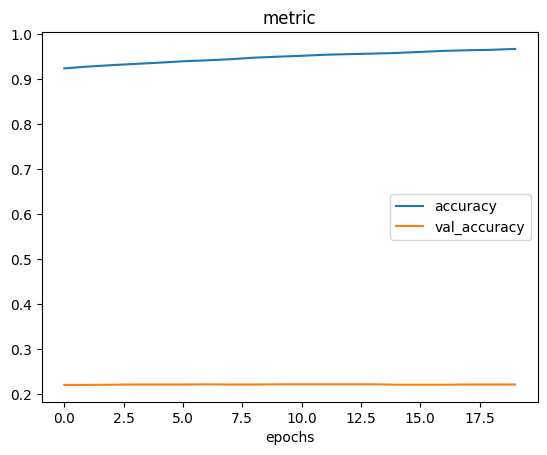

In [188]:
results[['accuracy', 'val_accuracy']].plot(title='metric')
plt.xlabel('epochs')

---
© 株式会社キカガク及び国立大学法人 豊橋技術科学大学